# Individuare la rete GTFS per TSULKI

In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import os
import requests
import zipfile
from shapely.geometry import Point, LineString, Polygon
import shapely
import folium
gtfdir='gtfs'
zipfilegtfs = 'arst-cagliari-it.zip'
urlzip = 'http://arstspa.info/arst-cagliari-it.zip'

![](https://www.transitwiki.org/TransitWiki/images/f/ff/GTFS_data_model_diagram.PNG)

## scaricamento files

In [2]:
if not os.path.exists(gtfdir):
    os.mkdir(gtfdir)

In [3]:
r = requests.get(urlzip,allow_redirects=True)
open(zipfilegtfs, 'wb').write(r.content)

1853779

In [4]:
with zipfile.ZipFile(zipfilegtfs,"r") as zip_ref:
    zip_ref.extractall(gtfdir)

In [6]:
comuni_italiani = gpd.read_file("Com01012019/Com01012019_WGS84.shp",driver="ESRI Shapefile")

In [7]:
listacomuni=["Iglesias", "Fluminimaggiore", "Buggeru","Guspini"]

## individuazione area di fluminimaggiore

In [8]:
fluminimaggiore= comuni_italiani[comuni_italiani.COMUNE=='Fluminimaggiore']

In [9]:
restoitalia = comuni_italiani[comuni_italiani.COMUNE!='Fluminimaggiore']

## e dei comuni confinanti

In [10]:
area = fluminimaggiore.geometry
id = int(fluminimaggiore.index[0])
for index, row in restoitalia.iterrows():
    if (fluminimaggiore.geometry.touches(row.geometry).bool() == True):
        area = area.union(row.geometry)
        

In [11]:
area = area[id]

In [12]:
comuni_italiani.crs

{'init': 'epsg:32632'}

## caricamento dei dati gtfs per categoria

In [13]:
stops = pd.read_csv(gtfdir + os.sep + 'stops.txt')
stop_times = pd.read_csv(gtfdir + os.sep + "stop_times.txt")
trips = pd.read_csv(gtfdir + os.sep + "trips.txt")
routes = pd.read_csv(gtfdir + os.sep + "routes.txt")
agency = pd.read_csv(gtfdir + os.sep + "agency.txt")
shapes = pd.read_csv(gtfdir + os.sep + "shapes.txt")
calendar = pd.read_csv(gtfdir + os.sep + 'calendar.txt')
calendar_dates = pd.read_csv(gtfdir + os.sep + "calendar_dates.txt")
fare_rules = pd.read_csv(gtfdir + os.sep + "fare_rules.txt",low_memory=False)
fare_attributes = pd.read_csv(gtfdir + os.sep + "fare_attributes.txt")
transfers = pd.read_csv(gtfdir + os.sep + "transfers.txt")

In [14]:
geometry = [Point(xy) for xy in zip(stops.stop_lon, stops.stop_lat)]
crs = {'init': 'epsg:4326'}
stops = gpd.GeoDataFrame(stops, crs=crs, geometry=geometry)

In [15]:
#x= stops.unary_union.envelope.centroid.x
#y = stops.unary_union.envelope.centroid.y

In [16]:
#m = folium.Map([y,x], zoom_start=7, tiles="OpenStreetMap")
#folium.GeoJson(stops.to_json()).add_to(m)
#m

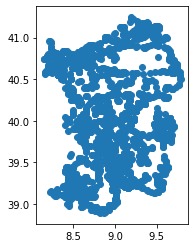

In [17]:
stops.plot()

In [18]:
results = []
for index, row in stops.to_crs(comuni_italiani.crs).iterrows():
    if (area.contains(row.geometry)):
        results.append(index)

## filtro nell'area di interesse delle fermate

In [19]:
stops_comuni = stops[stops.index.isin(results)]

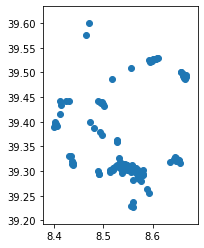

In [20]:
stops_comuni.plot()

In [21]:
x= stops_comuni.unary_union.envelope.centroid.x
y = stops_comuni.unary_union.envelope.centroid.y
m = folium.Map([y,x], zoom_start=10, tiles="OpenStreetMap")
folium.GeoJson(stops_comuni.to_json()).add_to(m)
m

In [22]:
stopids = list(stops_comuni.stop_id.values)

In [23]:
stop_times_comuni = stop_times[stop_times.stop_id.isin(stopids)]

In [24]:
tripids = list(stop_times_comuni.trip_id.unique())

In [25]:
trips_comuni = trips[trips.trip_id.isin(tripids)]

In [26]:
trips_comuni

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
859,205,FER,4896,FLUMINIMAGGIORE,1,NaN,NaN,NaN,1
860,205,SCO,4897,ARBUS CARDAXIUS,1,NaN,NaN,NaN,1
861,205,FER,4898,ARBUS CARDAXIUS,1,NaN,NaN,NaN,1
865,205,GIO,4902,ARBUS CARDAXIUS,1,NaN,NaN,NaN,1
866,205,FER,4903,ARBUS CARDAXIUS,1,NaN,NaN,NaN,1
871,205,SCO,4908,GUSPINI VIA GRAMSCI 22,1,NaN,NaN,NaN,1
872,205,FER,4909,FLUMINIMAGGIORE,1,NaN,NaN,NaN,1
874,205,FER,4911,ARBUS CARDAXIUS,1,NaN,NaN,NaN,1
875,205,SCO,4912,GUSPINI IS BOINARGIUS SUD,1,NaN,NaN,NaN,1
878,205,FER,4915,GUSPINI IS BOINARGIUS SUD,1,NaN,NaN,NaN,1


In [27]:
routeids = list(trips_comuni.route_id.unique())
routes_comuni = routes[routes.route_id.isin(routeids)]
agencyids = list(routes_comuni.agency_id.unique())
agency_comuni = agency[agency.isin(agencyids)]
shapeids = list(trips_comuni.shape_id.unique())
shapes_comuni = shapes[shapes.shape_id.isin(shapeids)]
fare_rules_comuni = fare_rules[fare_rules.route_id.isin(routeids)]
fareids = list(fare_rules_comuni.fare_id.unique())
fare_attributes_comuni = fare_attributes[fare_attributes.fare_id.isin(fareids)]
transfers_comuni=transfers[transfers.from_stop_id.isin(stopids)]
transfers_comuni=transfers[transfers.to_stop_id.isin(stopids)]

In [28]:
agency

,agency_id,agency_name,agency_url,agency_timezone,agency_lang,agency_phone,agency_fare_url
0,ARST SPA,ARST SpA - Trasporti Regionali Della Sardegna,http://arst.sardegna.it/,Europe/Rome,it,(39) 800 865 042,http://arst.sardegna.it/titoli_e_tariffe.html


## individuazione delle sole fermate che si collegano con la zona di interesse

### caricamento aree di studio

In [29]:
area_di_studio = gpd.read_file("data/area_studio.shp",driver="ESRI Shapefile")

### intersezione fra aree di studio e punti

In [30]:
idx_stops_area = []
for index, row in stops.iterrows():
    for idx, area in area_di_studio.iterrows():
        if row.geometry.within(area.geometry):
            idx_stops_area.append(index)
            break

In [31]:
idx_stops_area

[676, 677, 678, 679, 680, 681, 682, 683, 715, 784, 788, 789, 790, 791]

In [32]:
stops_area = stops[stops.index.isin(idx_stops_area)]

In [33]:
x= stops_area.unary_union.envelope.centroid.x
y = stops_area.unary_union.envelope.centroid.y
m = folium.Map([y,x], zoom_start=10, tiles="OpenStreetMap")
folium.GeoJson(stops_area.to_json()).add_to(m)
m

In [34]:
stops_area.stop_id.values

array(['B_1516', 'B_8353', 'B_21066', 'B_80582', 'B_80583', 'B_80585',
       'B_8062', 'B_8072', 'B_8123', 'B_8045', 'B_8052', 'B_80616',
       'B_80617', 'B_80618'], dtype=object)

In [35]:
stops_times_area = stop_times[stop_times.stop_id.isin(stops_area.stop_id.values)]

In [36]:
trip_id_area = stops_times_area.trip_id.unique()

In [37]:
trip_id_area = list(trip_id_area)

In [38]:
trips_area = trips[trips.trip_id.isin(trip_id_area)]

In [39]:
trips_area

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
859,205,FER,4896,FLUMINIMAGGIORE,1,NaN,NaN,NaN,1
872,205,FER,4909,FLUMINIMAGGIORE,1,NaN,NaN,NaN,1
900,205,FER,5075,ARBUS GENNA E FRONGIA 53,0,NaN,NaN,NaN,1
910,205,FER,5085,SANLURI AUTOSTAZIONE,0,NaN,NaN,NaN,1
2819,804,FER,16258,IGLESIAS STAZIONE FS,1,NaN,NaN,NaN,1
2820,804,FER,16259,IGLESIAS STAZIONE FS,1,NaN,NaN,NaN,1
2821,804,SCO,16260,IGLESIAS PIAZZA CAVALLERA CROCIFISSO,1,NaN,NaN,NaN,1
2822,804,SCO,16261,IGLESIAS PIAZZA CAVALLERA CROCIFISSO,1,NaN,NaN,NaN,1
2823,804,GIO,16262,IGLESIAS STAZIONE FS,1,NaN,NaN,NaN,1
2824,804,FER,16263,FLUMINIMAGGIORE,1,NaN,NaN,NaN,1


In [40]:
routeids = list(trips_area.route_id.unique())

In [41]:
routeids

['205', '804', '808', '840', '857']

In [42]:
routes_area = routes[routes.route_id.isin(routeids)]

In [43]:
routes_area

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
37,205,ARST SPA,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE,NaN,3,http://www.arstspa.info/205.pdf,0000FF,ffffff
152,804,ARST SPA,Linea 804,BUGGERRU - IGLESIAS,NaN,3,http://www.arstspa.info/804.pdf,0000FF,ffffff
156,808,ARST SPA,Linea 808,MASUA - IGLESIAS - DOMUSNOVAS,NaN,3,http://www.arstspa.info/808.pdf,0000FF,ffffff
187,840,ARST SPA,Linea 840,MASUA - DOMUSNOVAS,NaN,3,http://www.arstspa.info/840.pdf,0000FF,ffffff
204,857,ARST SPA,Linea 857,PORTIXEDDU - FLUMINIMAGGIORE,NaN,3,http://www.arstspa.info/857.pdf,0000FF,ffffff


## recupero tutti le fermate di questi trips

In [44]:
stop_times_area = stop_times[stop_times.trip_id.isin(trip_id_area)]

In [45]:
stop_id_area = list(stop_times_area.stop_id.unique())

In [46]:
stops_area = stops[stops.stop_id.isin(stop_id_area)]

In [47]:
stops_area.shape

(81, 9)

In [48]:
x= stops_area.unary_union.envelope.centroid.x
y = stops_area.unary_union.envelope.centroid.y
m = folium.Map([y,x], zoom_start=10, tiles="OpenStreetMap")
folium.GeoJson(stops_area.to_json()).add_to(m)
m

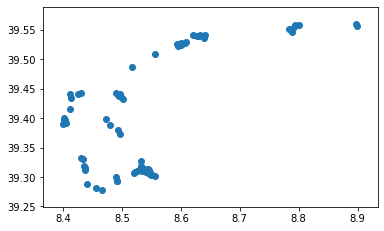

In [49]:
stops_area.plot()

In [50]:
routeids = list(trips_area.route_id.unique())
routes_area = routes[routes.route_id.isin(routeids)]
agencyids = list(routes_area.agency_id.unique())
agency_area = agency[agency.isin(agencyids)]
shapeids = list(trips_area.shape_id.unique())
shapes_area = shapes[shapes.shape_id.isin(shapeids)]
fare_rules_area = fare_rules[fare_rules.route_id.isin(routeids)]
fareids = list(fare_rules_area.fare_id.unique())
fare_attributes_area = fare_attributes[fare_attributes.fare_id.isin(fareids)]
transfers_area=transfers[transfers.from_stop_id.isin(stopids)]
transfers_area=transfers[transfers.to_stop_id.isin(stopids)]

In [51]:
stops_times_area.to_csv("stop_times.txt",index=False)

In [52]:
stops_area.drop(columns=['geometry']).to_csv('stops.txt',index=False)

In [53]:
routes_area.to_csv('routes.txt',index=False)
trips_area.to_csv("trips.txt",index=False)
shapes_area.to_csv('shapes.txt',index=False)
agency.to_csv('agency.txt',index=False)
fare_attributes_area.to_csv('fare_attributes.txt',index=False)
fare_rules_area.to_csv('fare_rules.txt',index=False)
calendar.to_csv('calendar.txt',index=False)
calendar_dates.to_csv('calendar_dates.txt',index=False)

In [54]:
gtfs_sulki = 'gtfs_tsulki.zip'

In [55]:
zf = zipfile.ZipFile(gtfs_sulki, mode='w')
try:
    zf.write('routes.txt')
    zf.write('trips.txt')
    zf.write('shapes.txt')
    zf.write('agency.txt')
    zf.write('fare_attributes.txt')
    zf.write('fare_rules.txt')
    zf.write('calendar.txt')
    zf.write('calendar_dates.txt')
    zf.write('stops.txt')
    zf.write('stop_times.txt')
finally:
    zf.close()

In [56]:
from shapely import wkt
bus_zones = stops_area.dissolve(by='zone_id').convex_hull.to_frame().reset_index()

In [64]:
bus_zones = bus_zones.rename({0: 'coordinates'}, axis='columns')

In [66]:
bus_zones['coordinates'] = bus_zones['coordinates'].apply(lambda x: x.to_wkt())

In [67]:
bus_zones['coordinates'] = bus_zones['coordinates'].apply(wkt.loads)

In [68]:
bus_zones = gpd.GeoDataFrame(bus_zones, geometry='coordinates')

In [69]:
x= bus_zones.unary_union.envelope.centroid.x
y = bus_zones.unary_union.envelope.centroid.y
m = folium.Map([y,x], zoom_start=10, tiles="OpenStreetMap")
folium.GeoJson(bus_zones.to_json()).add_to(m)
m

In [70]:
import geocoder

In [71]:
bus_zones['coordinates'].centroid.x

0     8.490799
1     8.413899
2     8.495887
3     8.453834
4     8.536274
5     8.432204
6     8.437031
7     8.484895
8     8.567843
9     8.633810
10    8.790701
11    8.898567
dtype: float64

In [72]:
g = geocoder.arcgis([45.15, -75.14], method='reverse')

In [73]:
def name_zones(point):
    value = geocoder.arcgis([point.centroid.y,point.centroid.x], method='reverse')
    name = value.json['raw']['address']['City']
    shortname =  value.json['raw']['address']['ShortLabel']
    if shortname == "Corso Pan di Zucchero":
        name = "Nebida"
    if shortname == "Masua":
        name = shortname
    if shortname == "Via dei Forni":
        name = "Bindua"
    if shortname == "Buggerru":
        if point.centroid.y == 8.400499999999999:
            name = "Buggerru"
        else:
            name = "Sant'Angelo"
    if shortname == "Gonnesa":
        name = "Fontanamare"
    if shortname == "Via Crocifisso 11-47":
        name = "Inglesias"
    return name

In [74]:
bus_zones['zone_name'] = bus_zones['coordinates'].apply(lambda x: name_zones(x))

In [75]:
bus_zones

,zone_id,coordinates,zone_name
0,94,"POLYGON ((8.491099999999999 39.29333, 8.489133...",Bindua
1,95,"POLYGON ((8.400499999999999 39.39, 8.401383000...",Sant'Angelo
2,103,"POLYGON ((8.500966999999999 39.43281, 8.490133...",Fluminimaggiore
3,105,"POLYGON ((8.465833 39.27866, 8.455653 39.28201...",Fontanamare
4,106,"POLYGON ((8.556533 39.30206, 8.5205 39.30666, ...",Inglesias
5,110,"LINESTRING (8.430408 39.33145, 8.4339999999999...",Masua
6,114,"POLYGON ((8.43745 39.31158, 8.436633 39.31451,...",Nebida
7,121,"POLYGON ((8.497216999999999 39.37373, 8.480582...",Sant'Angelo
8,440,"POLYGON ((8.516550000000001 39.4864, 8.555325 ...",Arbus
9,448,"POLYGON ((8.639972999999999 39.53609, 8.630614...",Guspini


# calcoli su gtfs

In [76]:
import networkx as nx
import osmnx as ox
import numpy as np
import peartree as pt

In [77]:
#path="arst-cagliari-it.zip" 
path="gtfs_tsulki.zip"

In [78]:
feed = pt.get_representative_feed(path)

In [79]:
start = 3*60*60  # 3:00
end = 24*60*60  # 24:00
G = pt.load_feed_as_graph(feed, start, end)

/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return (np.isnan(y), lambda z: z.nonzero()[0])
/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return (np.isnan(y), lambda z: z.nonzero()[0])
/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return (np.isnan(y), lambda z: z.nonzero()[0])
/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and w

/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return (np.isnan(y), lambda z: z.nonzero()[0])
/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return (np.isnan(y), lambda z: z.nonzero()[0])
/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return (np.isnan(y), lambda z: z.nonzero()[0])
/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and w

(<Figure size 590.97x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa7601d1d30>)

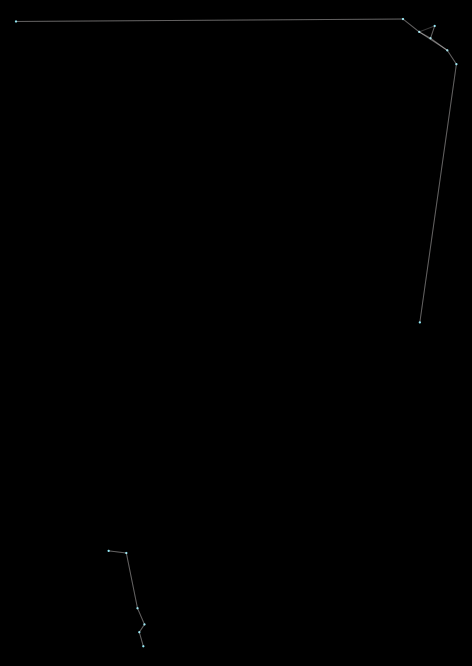

In [80]:
pt.generate_plot(G)

In [81]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

In [82]:
nx.write_gexf(G,'linee.gexf')

In [83]:
nodes = nx.betweenness_centrality(G)

In [84]:
nids = []
vals = []
for k in nodes.keys():
    nids.append(k)
    vals.append(nodes[k])
    
min(vals), np.array(vals).mean(), max(vals)
# prints (0.0, 0.0057453979174797599, 0.11406771048983973)

(0.0, 0.05173992673992673, 0.1378205128205128)

In [85]:
vals_adj = []
m = max(vals)
for v in vals:
    if v == 0:
        vals_adj.append(0)
    else:
        r = (v/m)
        vals_adj.append(r * 0.01)



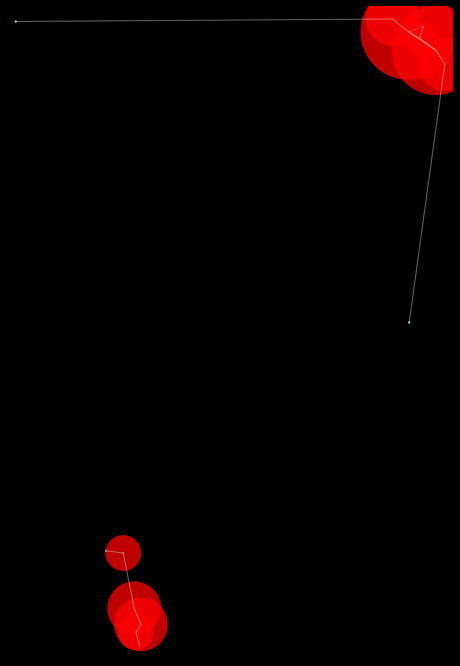

In [86]:
fig, ax = pt.generate_plot(G)
ps = []
for nid, buff_dist in zip(nids, vals_adj):
    n = G.node[nid]
    if buff_dist > 0:
        p = Point(n['x'], n['y']).buffer(buff_dist)
        ps.append(p)
    
gpd.GeoSeries(ps).plot(ax=ax, color='r', alpha=0.75)

## altro

In [87]:
import osmnx as ox

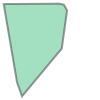

In [88]:
boundary = gpd.GeoSeries(
    [Point(n['x'], n['y']) for i, n in G.nodes(data=True)]
    ).unary_union.convex_hull

# Visually inspect
boundary


In [89]:
%time Gwalk = ox.graph_from_polygon(boundary, network_type='walk')

CPU times: user 2.86 s, sys: 23.3 ms, total: 2.89 s
Wall time: 5.37 s


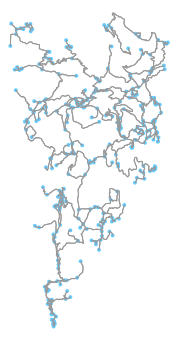

(<Figure size 280.723x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa745ffdf28>)

In [90]:
ox.plot_graph(Gwalk)

In [91]:
list(G.edges(data=True))[0]

('0ATG3_B_1516', '0ATG3_B_21066', {'length': 60.0, 'mode': 'transit'})

In [92]:
list(Gwalk.edges(data=True))[0]

(3775571969,
 5729998166,
 {'osmid': 81272200,
  'lanes': '2',
  'ref': 'SP83',
  'highway': 'secondary',
  'maxspeed': '30',
  'oneway': False,
  'length': 375.62199999999996,
  'geometry': <shapely.geometry.linestring.LineString at 0x7fa7601ca908>})

In [93]:
%%time

# Edge length in peartree is represented in seconds
# while in OSMnx it is in meters, so we need to convert those values
# down to seconds, based on some walk speed
walk_speed = 4.5  # about 3 miles per hour

# Make a copy of the graph in case we make a mistake
Gwalk_adj = Gwalk.copy()

# Iterate through and convert lengths to seconds
for from_node, to_node, edge in Gwalk_adj.edges(data=True):
    orig_len = edge['length']
    
    # Note that this is a MultiDiGraph so there could
    # be multiple indices here, I naively assume this is not
    # the case
    Gwalk_adj[from_node][to_node][0]['orig_length'] = orig_len

    # Conversion of walk speed and into seconds from meters
    kmph = (orig_len / 1000) / walk_speed
    in_seconds = kmph * 60 * 60
    Gwalk_adj[from_node][to_node][0]['length'] = in_seconds
    
    # And state the mode, too
    Gwalk_adj[from_node][to_node][0]['mode'] = 'walk'

CPU times: user 12.4 ms, sys: 4.05 ms, total: 16.5 ms
Wall time: 16.1 ms


In [94]:
list(Gwalk_adj.edges(data=True))[0]

(3775571969,
 5729998166,
 {'osmid': 81272200,
  'lanes': '2',
  'ref': 'SP83',
  'highway': 'secondary',
  'maxspeed': '30',
  'oneway': False,
  'length': 300.4976,
  'geometry': <shapely.geometry.linestring.LineString at 0x7fa7601ca908>,
  'orig_length': 375.62199999999996,
  'mode': 'walk'})

In [95]:
list(G.nodes(data=True))[0]

('0ATG3_B_1516',
 {'boarding_cost': 3212.7272727272725, 'y': 39.43569, 'x': 8.499122999999999})

In [96]:
# As you can see we are missing the
# boarding cost for the walk network nodes (which
# is just zero)
list(Gwalk_adj.nodes(data=True))[0]

(3775571969, {'y': 39.3406717, 'x': 8.4397771, 'osmid': 3775571969})

In [97]:
# So this should be easy - just go through all nodes
# and make them have a 0 cost to board
for i, node in Gwalk_adj.nodes(data=True):
    Gwalk_adj.node[i]['boarding_cost'] = 0

In [98]:
# Now that we have a formatted walk network
# it should be easy to reload the peartree graph
# and stack it on the walk network
start = 2 * 60 * 60
end = 24 * 60 * 60

# Note this will be a little slow - an optimization here would be
# to have coalesced the walk network
%time G2 = pt.load_feed_as_graph(feed, start, end, existing_graph=Gwalk_adj)

/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return (np.isnan(y), lambda z: z.nonzero()[0])
/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return (np.isnan(y), lambda z: z.nonzero()[0])
/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return (np.isnan(y), lambda z: z.nonzero()[0])
/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and w

/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return (np.isnan(y), lambda z: z.nonzero()[0])
/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return (np.isnan(y), lambda z: z.nonzero()[0])
/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return (np.isnan(y), lambda z: z.nonzero()[0])
/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and w

CPU times: user 849 ms, sys: 8.55 ms, total: 858 ms
Wall time: 841 ms


In [99]:
# This is an issue that needs cleaning up
# slash I need to look into it more
# but some nodes that should have been
# cleaned out remain
print('All nodes', len(G2.nodes()))
bad_ns = [i for i, n in G2.nodes(data=True) if 'x' not in n]
print('Bad nodes count', len(bad_ns))

for bad_n in bad_ns:
    # Make sure they do not conenct to anything
    if len(G2[bad_n]) > 0:
        # This should not happen
        print(bad_n)

    else:
        # So just drop them
        G2.remove_node(bad_n)

All nodes 365
Bad nodes count 1


(<Figure size 573.705x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa7601292e8>)

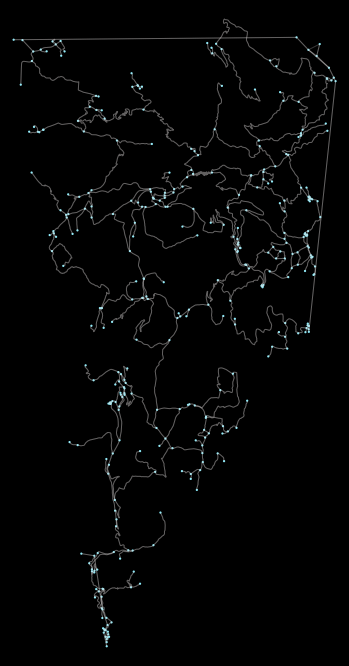

In [100]:
pt.plot.generate_plot(G2)

## ancora altro
http://kuanbutts.com/2018/03/15/comparative-routes-mpl/

In [101]:
#G = pt.load_feed_as_graph(feed, 2*60*60, 24*60*60, exempt_internal_edge_imputation=False)

In [102]:
G = pt.load_feed_as_graph(feed, start, end)

/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return (np.isnan(y), lambda z: z.nonzero()[0])
/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return (np.isnan(y), lambda z: z.nonzero()[0])
/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return (np.isnan(y), lambda z: z.nonzero()[0])
/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and w

/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return (np.isnan(y), lambda z: z.nonzero()[0])
/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return (np.isnan(y), lambda z: z.nonzero()[0])
/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return (np.isnan(y), lambda z: z.nonzero()[0])
/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/peartree/toolkit.py:159: FutureWarning: Series.nonzero() is deprecated and w

## Giocare con i GTFS
http://simplistic.me/playing-with-gtfs.html

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
import partridge as ptg
import datetime
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5) # set default size of plots

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5) # set default size of plots

sns.set(style="white", rc={"axes.facecolor": (1, 1, 1, 0)})
sns.set_context("talk")
sns.set_palette('Set2', 10)

We'll start with one tidy dataset for stop_times, I'll use partridge for filtering on dates.

In [104]:
### setup
_date, service_ids = ptg.read_busiest_date(gtfs_sulki)

view = {
    'trips.txt': {'service_id': service_ids},
}

feed = ptg.load_feed(gtfs_sulki, view)

In [105]:
s = feed.stops
s.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,wheelchair_boarding
0,B_1516,1516,FLUMINIMAGGIORE,NaN,39.43569,8.499123,103,NaN
1,B_8353,8353,FLUMINIMAGGIORE CAMPO SPORTIVO,NaN,39.44077,8.496562,103,NaN
2,B_21066,21066,FLUMINIMAGGIORE VIA V.EMANUELE 458,NaN,39.43953,8.493424,103,NaN
3,B_80582,80582,FLUMINIMAGGIORE VIA V.EMANUELE 301,NaN,39.43821,8.495717,103,NaN
4,B_80583,80583,FLUMINIMAGGIORE VIA V.EMANUELE 4,NaN,39.43281,8.500967,103,NaN


Before we build our first stop times tidy DataFrame, we need zone name data.

Note: I'm disregarding FromDate and ToDate and just dropping duplicates. So we will give wrong zone names for zone changes within the GTFS 60 day period.


In [106]:
ts = (bus_zones[['zone_id', 'zone_name']].drop_duplicates().set_index('zone_id').iloc[:,0])
ts.head()

zone_id
94              Bindua
95         Sant'Angelo
103    Fluminimaggiore
105        Fontanamare
106          Inglesias
Name: zone_name, dtype: object

In [107]:
zones = feed.stops[['stop_code','zone_id']].drop_duplicates()

In [108]:
def getname(zone_id):
    name = ts[int(zone_id)]
    return name

In [109]:
zones['zone_name'] = zones['zone_id'].apply(lambda x: getname(x))

In [110]:
zones

,stop_code,zone_id,zone_name
0,1516,103,Fluminimaggiore
1,8353,103,Fluminimaggiore
2,21066,103,Fluminimaggiore
3,80582,103,Fluminimaggiore
4,80583,103,Fluminimaggiore
5,80585,103,Fluminimaggiore
6,8062,95,Sant'Angelo
7,8072,121,Sant'Angelo
8,8123,110,Masua
9,8045,110,Masua


In [111]:
def to_timedelta(df):
    '''
    Turn time columns into timedelta dtype
    '''
    cols = ['arrival_time']
    numeric = df[cols].apply(pd.to_timedelta, unit='s')
    df = df.copy()
    df[cols] = numeric
    return df

f = (feed.stop_times[['trip_id', 'arrival_time', 'stop_id']]
     .assign(date = datetime.date(2017, 12, 21))
     .merge(s[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'stop_code']], on='stop_id')
     # Much faster joins and slices with Categorical dtypes
     .merge(zones, how='left')
     .assign(zone_name=lambda x: pd.Categorical(x['zone_name']))
     .pipe(to_timedelta)
    )
f.head()

,trip_id,arrival_time,stop_id,date,stop_name,stop_lat,stop_lon,stop_code,zone_id,zone_name
0,4896,07:28:00,B_21066,2017-12-21,FLUMINIMAGGIORE VIA V.EMANUELE 458,39.43953,8.493424,21066,103,Fluminimaggiore
1,4909,15:08:00,B_21066,2017-12-21,FLUMINIMAGGIORE VIA V.EMANUELE 458,39.43953,8.493424,21066,103,Fluminimaggiore
2,5075,07:36:00,B_21066,2017-12-21,FLUMINIMAGGIORE VIA V.EMANUELE 458,39.43953,8.493424,21066,103,Fluminimaggiore
3,5085,15:16:00,B_21066,2017-12-21,FLUMINIMAGGIORE VIA V.EMANUELE 458,39.43953,8.493424,21066,103,Fluminimaggiore
4,16258,05:58:00,B_21066,2017-12-21,FLUMINIMAGGIORE VIA V.EMANUELE 458,39.43953,8.493424,21066,103,Fluminimaggiore


Overall daily stops

In [112]:
f.shape[0]

244

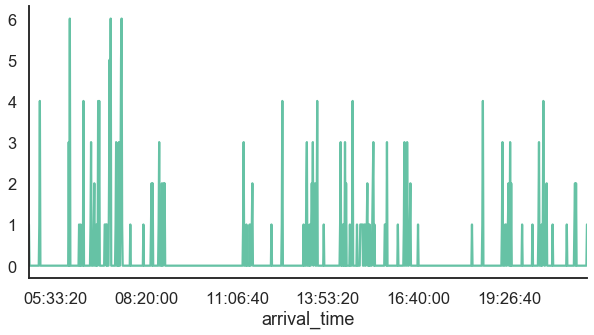

In [113]:
f_1T = f.set_index(['arrival_time']).resample('1T')
f_1T.size().plot()
sns.despine()

In [114]:
f_1T.size().reset_index().head()

,arrival_time,0
0,04:45:00,1
1,04:46:00,0
2,04:47:00,0
3,04:48:00,0
4,04:49:00,0


In [115]:
from statsmodels.nonparametric.smoothers_lowess import lowess
counts = f_1T.size().reset_index().rename(columns={0: 'size'})
smooth_counts = lowess(counts.iloc[:,1], counts.arrival_time, frac=0.01) 
counts['smooth'] = smooth_counts[:, 1]
counts = counts.set_index('arrival_time')
counts['ewm'] = counts['size'].ewm(span=10).mean()
counts.head()

,size,smooth,ewm
arrival_time,,,
04:45:00,1,0.0,1.000000
04:46:00,0,0.0,0.450000
04:47:00,0,0.0,0.269103
04:48:00,0,0.0,0.180446
04:49:00,0,0.0,0.128645


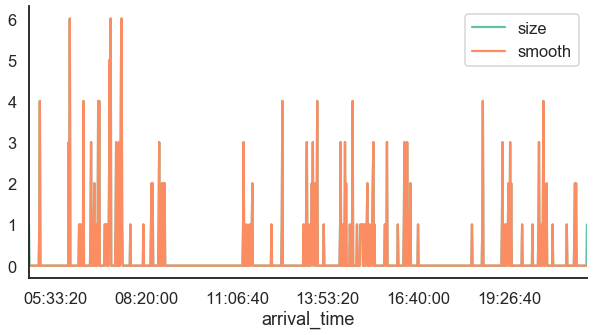

In [116]:
counts[['size', 'smooth']].plot()
sns.despine()

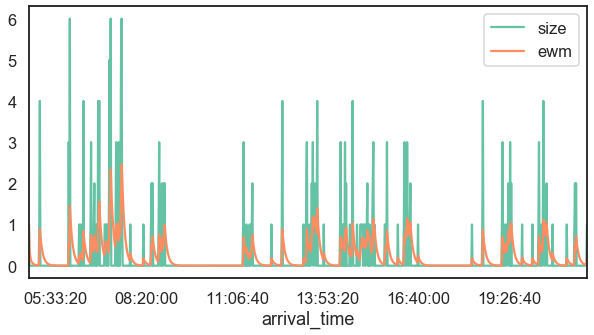

In [117]:
counts[['size', 'ewm']].plot()

In [118]:
# one minute counts
c10 = f_1T.size().reset_index().rename(columns={0: 'size'})
# extract minute smalll digit to a new column
c10 = c10.assign(minute=c10.arrival_time.dt.seconds//60%10)
# group the one minute counts into a two level MultiIndex by the 1 minute counts
# and a new resample by 10 minutes. the minute
c10 = c10.set_index('arrival_time').groupby([pd.Grouper(freq='10T'), 'minute']).mean()
# lets look at it in a meaningful way, we can see a peak at the 0  and 5
# (sparkline could be a good viz for this)
c10.reset_index().pivot('arrival_time', 'minute', 'size').iloc[6*7:6*9]

minute,0,1,2,3,4,5,6,7,8,9
arrival_time,,,,,,,,,,
11:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11:55:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12:05:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12:25:00,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12:55:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13:05:00,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0


/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


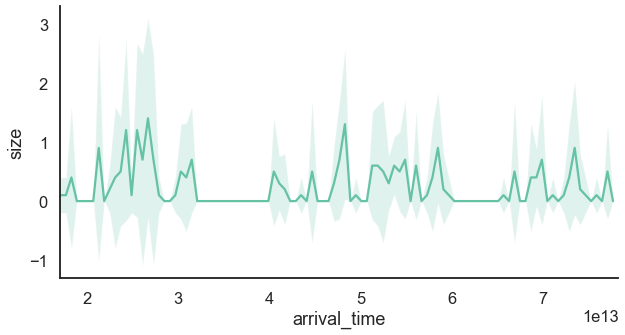

In [119]:
sns.tsplot(data=c10.reset_index(), time='arrival_time', unit='minute', value='size',
           ci='sd')
sns.despine()



The lower opacity color represents the standard deviation.

That's kind of simple to do on our own, so lets do this and some more.


In [120]:
f10 = f_1T.size().resample('10T').apply(['max', 'min', 'mean', 'std'])
f10['ci_l'] = f10['mean'] - f10['std']
f10['ci_h'] = f10['mean'] + f10['std']
f10.head()

,max,min,mean,std,ci_l,ci_h
arrival_time,,,,,,
04:45:00,1,0,0.1,0.316228,-0.216228,0.416228
04:55:00,1,0,0.1,0.316228,-0.216228,0.416228
05:05:00,4,0,0.4,1.264911,-0.864911,1.664911
05:15:00,0,0,0.0,0.000000,0.000000,0.000000
05:25:00,0,0,0.0,0.000000,0.000000,0.000000


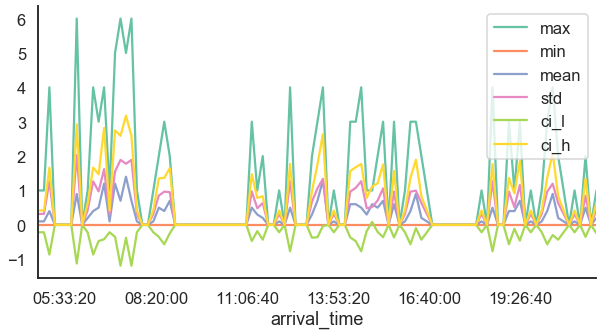

In [121]:
f10.plot()
sns.despine()

Let's finish with some zone slicing. Starting by getting the top zones overall

Kind of a teaser for future posts, where I'll dive deeper with more slices, groupings and some dynamic dashboarding (woohoo).

Start with getting the top ten zones:

In [122]:
top_zones = f.groupby('zone_name').size().sort_values(ascending=False).head(10)
top_zones.reset_index()

,zone_name,0
0,Fluminimaggiore,119
1,Nebida,76
2,Sant'Angelo,29
3,Masua,20


In [123]:
zone10 = (f[f.zone_name.isin(top_zones.index)].set_index('arrival_time')
          .groupby([pd.Grouper(freq='1T'), 'zone_name'])
          .size())
zones10 = zone10.reset_index().rename(columns={0: 'size'})
#reverse names so they will show nicely in plot
zones10 = zones10.assign(zone_name=lambda x: (x['zone_name'].str[::-1]))
zones10 = zones10.pivot('arrival_time', 'zone_name', 'size')

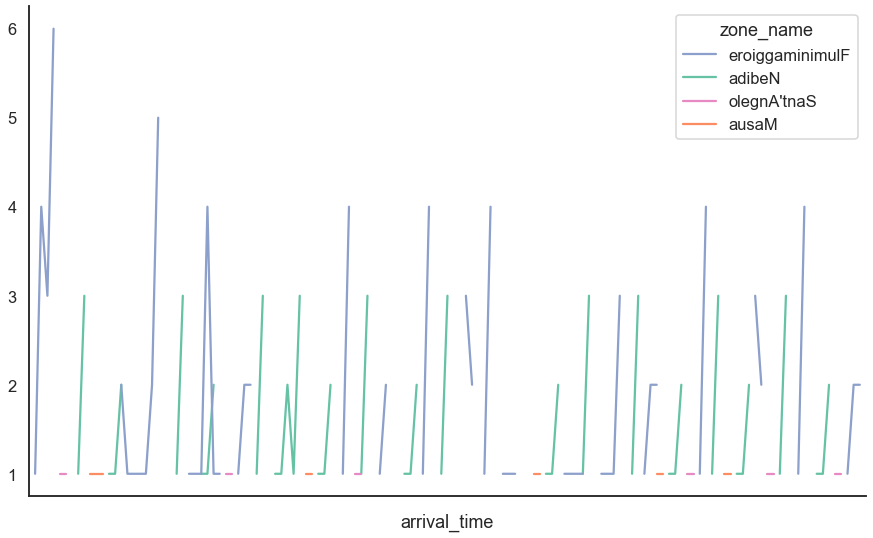

In [124]:
fig, ax = plt.subplots()
zones10.plot(figsize=(15,10), ax=ax)
handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by their rank (and do so in a very weird way :))
top_zones_rank = top_zones.reset_index()
labels, handles = zip(*sorted(zip(labels, handles), 
                              key=lambda t: top_zones_rank[top_zones_rank.zone_name==t[0][::-1]].index.tolist()[0]))
ax.legend(handles, labels, title="zone_name")

sns.despine()

# Concurrency
http://simplistic.me/playing-with-gtfs-ii-concurrency.html


In [125]:
## CHECK THE DATA
day = (2019,3,26)
service_ids_by_date = ptg.read_service_ids_by_date(gtfs_sulki)
service_ids = service_ids_by_date[datetime.date(2019, 3, 26)]

view = {
    'trips.txt': {'service_id': service_ids},
}

feed = ptg.load_feed(gtfs_sulki, view)


In [126]:
s = feed.stops
s.head()


,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,wheelchair_boarding
0,B_1516,1516,FLUMINIMAGGIORE,NaN,39.43569,8.499123,103,NaN
1,B_8353,8353,FLUMINIMAGGIORE CAMPO SPORTIVO,NaN,39.44077,8.496562,103,NaN
2,B_21066,21066,FLUMINIMAGGIORE VIA V.EMANUELE 458,NaN,39.43953,8.493424,103,NaN
3,B_80582,80582,FLUMINIMAGGIORE VIA V.EMANUELE 301,NaN,39.43821,8.495717,103,NaN
4,B_80583,80583,FLUMINIMAGGIORE VIA V.EMANUELE 4,NaN,39.43281,8.500967,103,NaN


In [127]:
r = feed.routes
r.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,205,ARST SPA,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE,NaN,3,http://www.arstspa.info/205.pdf,0000FF,ffffff
1,804,ARST SPA,Linea 804,BUGGERRU - IGLESIAS,NaN,3,http://www.arstspa.info/804.pdf,0000FF,ffffff
2,808,ARST SPA,Linea 808,MASUA - IGLESIAS - DOMUSNOVAS,NaN,3,http://www.arstspa.info/808.pdf,0000FF,ffffff
3,840,ARST SPA,Linea 840,MASUA - DOMUSNOVAS,NaN,3,http://www.arstspa.info/840.pdf,0000FF,ffffff


In [128]:
t = (feed.trips
     .assign(route_id=lambda x: pd.Categorical(x['route_id']))
    )
t.head()

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
0,205,FER,4896,FLUMINIMAGGIORE,1,NaN,NaN,NaN,1
1,205,FER,4909,FLUMINIMAGGIORE,1,NaN,NaN,NaN,1
2,205,FER,5075,ARBUS GENNA E FRONGIA 53,0,NaN,NaN,NaN,1
3,205,FER,5085,SANLURI AUTOSTAZIONE,0,NaN,NaN,NaN,1
4,804,FER,16258,IGLESIAS STAZIONE FS,1,NaN,NaN,NaN,1


In [129]:
def to_timedelta(df):
    '''
    Turn time columns into timedelta dtype
    '''
    cols = ['arrival_time', 'departure_time']
    numeric = df[cols].apply(pd.to_timedelta, unit='s')
    df = df.copy()
    df[cols] = numeric
    return df

f = (feed.stop_times[['trip_id', 'departure_time', 'arrival_time', 'stop_id']]
     .assign(date = datetime.date(2017, 12, 21))
     .merge(s[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'zone_id']], on='stop_id')
     # Much faster joins and slices with Categorical dtypes
     .merge(zones.groupby(['zone_id', 'zone_name']).size().reset_index()[['zone_id', 'zone_name']], on='zone_id')
     .assign(zone_id=lambda x: pd.Categorical(x['zone_id']))
     .assign(zone_name=lambda x: pd.Categorical(x['zone_name']))
     .merge(t[['trip_id', 'route_id']], on='trip_id')
     .merge(r[['route_id', 'route_short_name', 'route_long_name']], on='route_id')
     .assign(route_id=lambda x: pd.Categorical(x['route_id']))
     .pipe(to_timedelta)
    )
f.head()

,trip_id,departure_time,arrival_time,stop_id,date,stop_name,stop_lat,stop_lon,zone_id,zone_name,route_id,route_short_name,route_long_name
0,4896,07:28:00,07:28:00,B_21066,2017-12-21,FLUMINIMAGGIORE VIA V.EMANUELE 458,39.43953,8.493424,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
1,4896,07:30:00,07:30:00,B_1516,2017-12-21,FLUMINIMAGGIORE,39.43569,8.499123,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
2,4909,15:08:00,15:08:00,B_21066,2017-12-21,FLUMINIMAGGIORE VIA V.EMANUELE 458,39.43953,8.493424,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
3,4909,15:10:00,15:10:00,B_1516,2017-12-21,FLUMINIMAGGIORE,39.43569,8.499123,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
4,5075,07:36:00,07:36:00,B_21066,2017-12-21,FLUMINIMAGGIORE VIA V.EMANUELE 458,39.43953,8.493424,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE


In [130]:
f.dtypes

trip_id                      object
departure_time      timedelta64[ns]
arrival_time        timedelta64[ns]
stop_id                      object
date                         object
stop_name                    object
stop_lat                    float64
stop_lon                    float64
zone_id                    category
zone_name                  category
route_id                   category
route_short_name             object
route_long_name              object
dtype: object

## Stop and route top charts


In [131]:
f_no_nans = (f
             .assign(zone_name = lambda x: x.zone_name.cat.add_categories('').fillna(''))
             .assign(zone_id = lambda x: x.zone_id.cat.add_categories('').fillna(''))
             .assign(route_id = lambda x: x.route_id.cat.add_categories('').fillna(''))
            )
f_no_nans.fillna('')[f_no_nans.route_short_name.isnull()].head()



,trip_id,departure_time,arrival_time,stop_id,date,stop_name,stop_lat,stop_lon,zone_id,zone_name,route_id,route_short_name,route_long_name


In [132]:
route_counts = (f_no_nans.fillna('')
 .groupby(['zone_name', 'route_id', 'route_short_name', 'route_long_name'])
 .size().sort_values(ascending=False).head(20).to_frame().rename(columns={0:'count'}))
route_counts

,,,,count
zone_name,route_id,route_short_name,route_long_name,
Fluminimaggiore,804,Linea 804,BUGGERRU - IGLESIAS,111
Nebida,808,Linea 808,MASUA - IGLESIAS - DOMUSNOVAS,72
Sant'Angelo,804,Linea 804,BUGGERRU - IGLESIAS,29
Masua,808,Linea 808,MASUA - IGLESIAS - DOMUSNOVAS,18
Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE,8
Nebida,840,Linea 840,MASUA - DOMUSNOVAS,4
Masua,840,Linea 840,MASUA - DOMUSNOVAS,2


Stops per stop

In [133]:
top_stops = (s.set_index('stop_name')
             .loc[:,'stop_id']
             .map(f.stop_id.value_counts())
             .sort_values(ascending=False)
             .head(20).to_frame())

## On the road
### departure_time, arrival_time

In [134]:
def to_timedelta(df):
    '''
    Turn time columns into timedelta dtype
    '''
    cols = ['arrival_time', 'departure_time']
    numeric = df[cols].apply(pd.to_timedelta, unit='s')
    df = df.copy()
    df[cols] = numeric
    return df


se = (feed.stop_times.groupby(['trip_id'])
     .agg({'departure_time': 'min',
          'arrival_time': 'max'})
     .pipe(to_timedelta)
     .sort_values(['arrival_time', 'departure_time']))
se.head()

,departure_time,arrival_time
trip_id,,
16335,04:45:00,05:05:00
16336,06:00:00,06:17:00
16258,05:58:00,06:20:00
16343,06:25:00,06:25:00
19176,06:38:00,06:45:00



Counting how many buses are on the road (concurrency count)


In [135]:
departures = pd.Series(1, se.departure_time).resample('1Min').sum()
departures.head()


departure_time
04:45:00    1
04:46:00    0
04:47:00    0
04:48:00    0
04:49:00    0
Freq: T, dtype: int64

In [136]:
arrivals =  pd.Series(1, se.arrival_time).resample('T').sum()
arrivals.head()


arrival_time
05:05:00    1
05:06:00    0
05:07:00    0
05:08:00    0
05:09:00    0
Freq: T, dtype: int64

In [137]:
onroad = pd.concat([pd.Series(1, se.departure_time),  # departed add 1
                           pd.Series(-1, se.arrival_time)  # arrived substract 1
                           ]).resample('1Min').sum().cumsum().ffill()


In [138]:
df = (pd.concat([departures, arrivals, onroad], axis=1).reset_index()
        .rename(columns={'index': 'time', 0:'departures', 1:'arrivals', 2:'onroad'}))
df.head()

,time,departures,arrivals,onroad
0,04:45:00,1.0,NaN,1
1,04:46:00,0.0,NaN,1
2,04:47:00,0.0,NaN,1
3,04:48:00,0.0,NaN,1
4,04:49:00,0.0,NaN,1


In [139]:
idx = pd.DatetimeIndex(df.time+datetime.datetime(2019, 3, 26))
idx

DatetimeIndex(['2019-03-26 04:45:00', '2019-03-26 04:46:00',
               '2019-03-26 04:47:00', '2019-03-26 04:48:00',
               '2019-03-26 04:49:00', '2019-03-26 04:50:00',
               '2019-03-26 04:51:00', '2019-03-26 04:52:00',
               '2019-03-26 04:53:00', '2019-03-26 04:54:00',
               ...
               '2019-03-26 21:40:00', '2019-03-26 21:41:00',
               '2019-03-26 21:42:00', '2019-03-26 21:43:00',
               '2019-03-26 21:44:00', '2019-03-26 21:45:00',
               '2019-03-26 21:46:00', '2019-03-26 21:47:00',
               '2019-03-26 21:48:00', '2019-03-26 21:49:00'],
              dtype='datetime64[ns]', name='time', length=1025, freq=None)

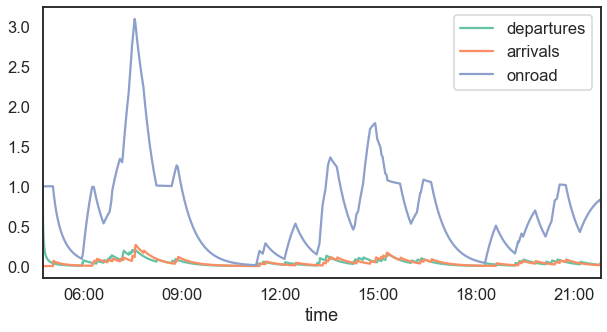

In [140]:
(df.assign(time=idx)
 .set_index('time')
 .resample('1min').sum()
 .ewm(span=60)
 .mean()
 .plot())

In [141]:
def to_numeric(df):
    '''
    Turn timedelta columns into numeric dtype
    '''
    cols = ['time']
    numeric = df[cols].apply(pd.to_numeric)
    df = df.copy()
    df[cols] = numeric
    return df

# we have to convert to numeric in order to use time in lmplot
melted_df = (df.pipe(to_numeric)
             .melt(id_vars=['time']))



/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


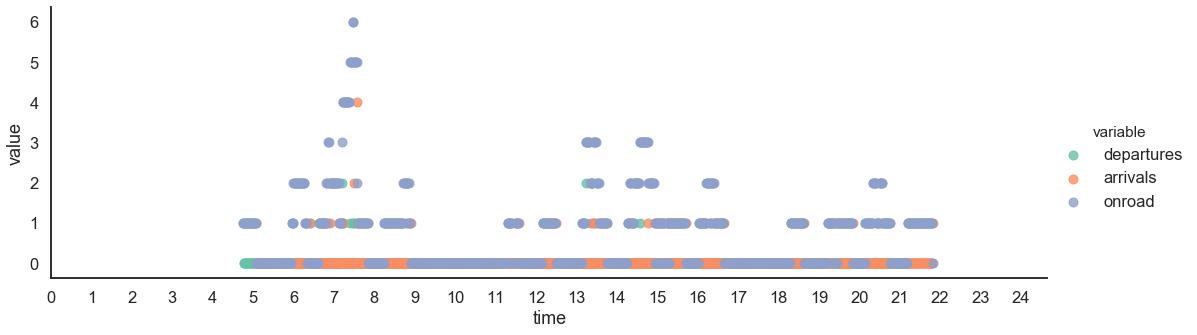

In [142]:
g = sns.lmplot(x="time", y="value", hue="variable", data=melted_df, 
           size=5, aspect=3, line_kws={'linewidth': 0}, ci=None)
g.set(xticks=np.arange(25)*60*60*1e9, xticklabels=np.arange(25))

/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


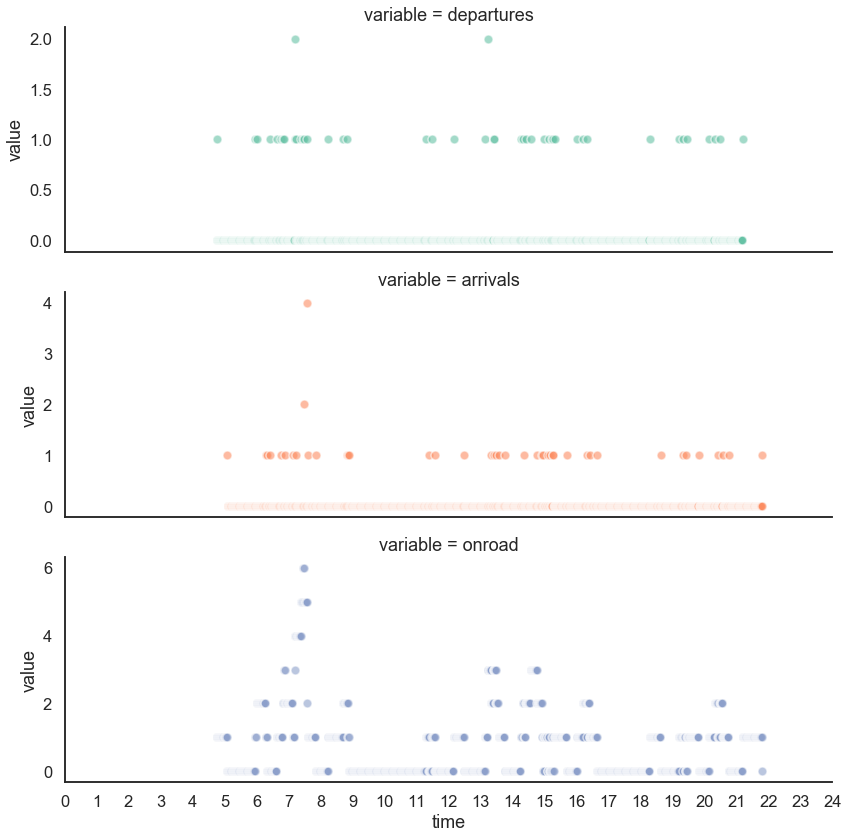

In [143]:
g = sns.FacetGrid(melted_df, row="variable", hue="variable", size=4, aspect=3, sharey=False)
g = g.map(plt.scatter, "time", "value", edgecolor="w", alpha=0.6)
g.set(xticks=np.arange(25)*60*60*1e9, xticklabels=np.arange(25))

/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/ipykernel_launcher.py:59: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.


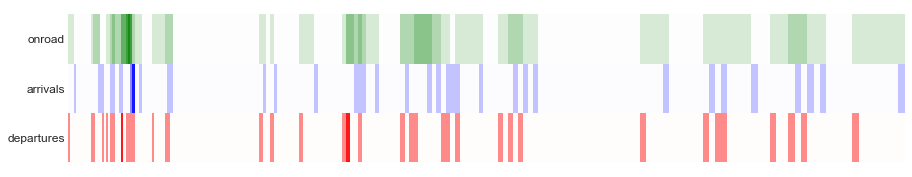

In [144]:
def makebarplot(df):
    time = df.iloc[:, 0]   # extract the x-axis data
    fig = plt.figure()            # get the matplotlib plot figure
    fig.set_size_inches(15, 3)     # set the size of the plot
    ax = fig.add_subplot(1, 1, 1) # add a plot to the figure; Subplot
    # is confusing, though.  The magical "(1, 1, 1)" here means there
    # will be one row, one column, and we are working with plot number
    # 1, all of which is the same as just one plot.  There is a little
    # more documentation on this at:
    # http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.subplot
    # turn off the borders (called spines)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # set all of the ticks to 0 length
    ax.tick_params(axis=u'both', which=u'both',length=0)
    # hide everything about the x-axis
    ax.axes.get_xaxis().set_visible(False)
    # remove grid
    ax.grid(linewidth=0)
    
    barwidth = 1                  # remove gaps between bars
    color = ["red", "blue", "green"] # set the colors for
    for row in range(1, len(color)+1): # make as many rows as colors
        # extract the correct column
        ongoing = df.iloc[:, row]
        # scale the data to the maximum
        ongoing = (ongoing / ongoing.max())

        # draw a black line at the left end
        left = 10
        border_width = 20
        d = border_width
        ax.barh(row, d, barwidth, color="black",
                left=left, edgecolor="none",
                linewidth=0)
        left += d
        # fill in the horizontal bar with the right color density
        # (alpha)
        for d, c in pd.concat((time, ongoing), axis=1).itertuples(index=False):
            ax.barh(row, d, barwidth,
                    alpha=0.9*c+.01,
                    color=color[row-1],
                    left=left,
                    edgecolor="none",
                    linewidth=0)
            left += d

        # draw a black line at the right end
        d = border_width
        ax.barh(row, d, barwidth,
                color="black",
                left=left, edgecolor="none",
                linewidth=0)
    # label the rows
    plt.yticks([1, 2, 3], ['departures', 'arrivals', 'onroad'], size=12)

makebarplot(df.fillna(0)
            .set_index('time').resample('5T').max().reset_index()
            .pipe(to_numeric))

/home/napo/Desktop/Sardegna/tsulki_data_analysis/env/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


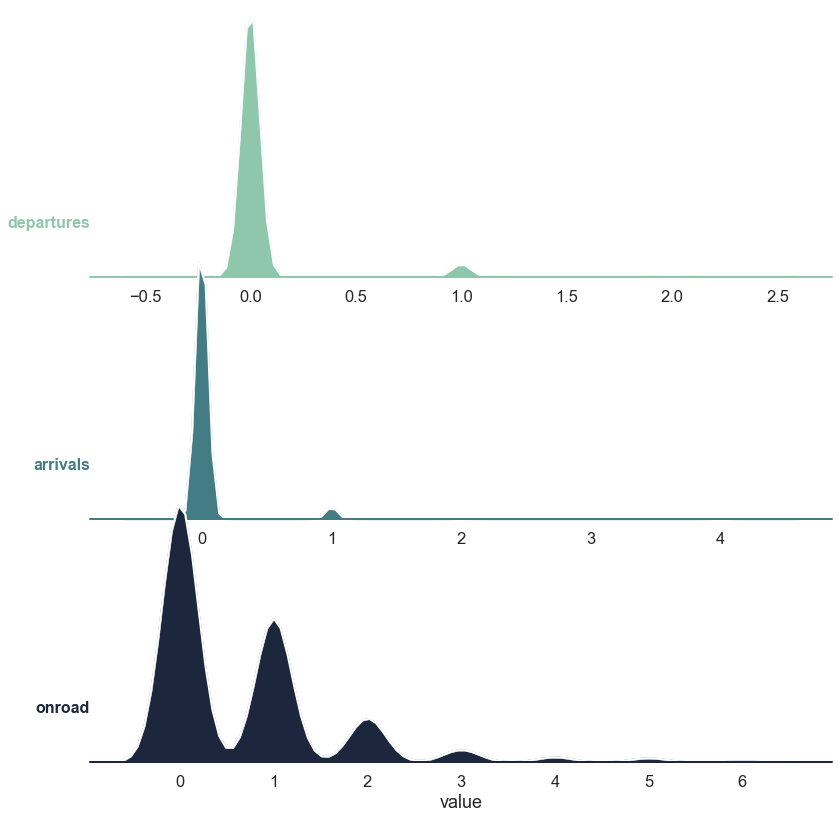

In [145]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(3, rot=-.4, light=.7)
g = sns.FacetGrid(melted_df, row="variable", hue="variable", aspect=3, size=4, palette=pal, sharex=False, sharey=False)

# Draw the densities in a few steps
g.map(sns.kdeplot, "value", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, size=16, fontweight="bold", color=color, 
            ha="right", va="center", transform=ax.transAxes)

g.map(label, "value")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.1)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

on-road per routes

In [146]:
route_filter = route_counts.reset_index().route_id
fr = (f[f.route_id.isin(route_filter)].groupby(['trip_id', 'route_id'], as_index=False)
     .agg({'departure_time': 'min',
          'arrival_time': 'max'})
     .pipe(to_timedelta)
     .sort_values(['arrival_time', 'departure_time']))
# converting the categorical to numerical
fr['route_id'] = fr['route_id'].cat.remove_unused_categories()
fr.head()

,trip_id,route_id,departure_time,arrival_time
13,16335,804,04:45:00,05:05:00
14,16336,804,06:00:00,06:17:00
0,16258,804,05:58:00,06:20:00
20,16343,804,06:25:00,06:25:00
42,19176,840,06:38:00,06:45:00


In [147]:
fr['route_id'].cat.categories

Index(['205', '804', '808', '840'], dtype='object')

In [148]:
departures = (fr[['departure_time', 'route_id']]
              .assign(count=1).rename(columns={'departure_time': 'time'}))
arrivals = (fr[['arrival_time', 'route_id']]
            .assign(count=-1).rename(columns={'arrival_time': 'time'}))

con = pd.concat([departures, arrivals]).set_index('time')


In [149]:
onroad_route = (con.groupby([pd.Grouper(freq='1Min'), 'route_id'])
                .sum()
                .unstack()
                .cumsum()
                .stack()
                .reset_index()
                .pipe(to_numeric))

ValueError: unit abbreviation w/o a number

In [150]:
g = sns.FacetGrid(onroad_route, hue='route_id', size=10, aspect=1)
g.map(plt.step, 'time', 'count', linewidth=1,).add_legend()
g.set(xticks=np.arange(25)*60*60*1e9, xticklabels=np.arange(25))


NameError: name 'onroad_route' is not defined

In [151]:
g = sns.FacetGrid(onroad_route, row='route_id', hue='route_id', size=1, aspect=10, 
                  row_order=route_filter,
                  margin_titles=True)
g.map(plt.step, 'time', 'count', linewidth=1)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=0)
g.set(yticks=[5, 10, 15])
g.set(xticks=np.arange(25)*60*60*1e9, xticklabels=np.arange(25))

[plt.setp(ax.texts, text="") for ax in g.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
g.set_titles(row_template = '{row_name}')
g.despine()

NameError: name 'onroad_route' is not defined

In [152]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [153]:
from bokeh.plotting import figure
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.palettes import inferno, magma

# web mercator coordinates (got them here https://epsg.io/map)
Center_Israel = x_range, y_range = ((3852120,3852120+10e4), (3729820,3729820+10e4/1.3))

plot_width  = int(540)
plot_height = int(plot_width//1.3)

def base_plot(tools='pan,wheel_zoom,box_zoom,reset', active_drag='pan', 
              active_scroll='wheel_zoom', toolbar_location='left',
              plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, active_drag=active_drag, active_scroll=active_scroll,
               toolbar_location=toolbar_location,
                plot_width=plot_width, plot_height=plot_height,
                x_range=x_range, y_range=y_range, outline_line_color=None,
                min_border=0, min_border_left=0, min_border_right=0,
                min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

def wgs84_to_web_mercator(df, lon="stop_lon", lat="stop_lat"):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

stops = (s[['stop_lon', 'stop_lat', 'stop_id', 'zone_id']].set_index('stop_id')
         .pipe(wgs84_to_web_mercator)
         .assign(counts = f.stop_id.value_counts())
         .sort_values(by='counts', ascending=False))

pal = inferno(256)
c256 = 255 - pd.cut(stops.counts.fillna(0), 256).cat.codes
colors = [pal[c] for _, c in c256.iteritems()]

options = dict(line_color=None, fill_color=colors, size=5)

p = base_plot()
p.add_tile(CARTODBPOSITRON)

p.circle(x=stops['x'], y=stops['y'], **options)
show(p)

In [154]:
from bokeh.plotting import figure
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.palettes import inferno, magma

# web mercator coordinates (got them here https://epsg.io/map)
Center_Israel = x_range, y_range = ((3852120,3852120+10e4), (3729820,3729820+10e4/1.3))

plot_width  = int(540)
plot_height = int(plot_width//1.3)

def base_plot(tools='pan,wheel_zoom,box_zoom,reset', active_drag='pan', 
              active_scroll='wheel_zoom', toolbar_location='left',
              plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, active_drag=active_drag, active_scroll=active_scroll,
               toolbar_location=toolbar_location,
                plot_width=plot_width, plot_height=plot_height,
                x_range=x_range, y_range=y_range, outline_line_color=None,
                min_border=0, min_border_left=0, min_border_right=0,
                min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

def wgs84_to_web_mercator(df, lon="stop_lon", lat="stop_lat"):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

stops = (s[['stop_lon', 'stop_lat', 'stop_id']].set_index('stop_id')
         .pipe(wgs84_to_web_mercator)
         .assign(counts = f.stop_id.value_counts())
         .sort_values(by='counts', ascending=False))

pal = inferno(256)
c256 = 255 - pd.cut(stops.counts.fillna(0), 256).cat.codes
colors = [pal[c] for _, c in c256.iteritems()]

options = dict(line_color=None, fill_color=colors, size=5)

p = base_plot()
p.add_tile(CARTODBPOSITRON)

p.circle(x=stops['x'], y=stops['y'], **options)
show(p)

In [155]:
f[f.route_id.isin(['205', '808'])] # Line 6 Modi'in Illit, the same holds for line 5


,trip_id,departure_time,arrival_time,stop_id,date,stop_name,stop_lat,stop_lon,zone_id,zone_name,route_id,route_short_name,route_long_name
0,4896,07:28:00,07:28:00,B_21066,2017-12-21,FLUMINIMAGGIORE VIA V.EMANUELE 458,39.43953,8.493424,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
1,4896,07:30:00,07:30:00,B_1516,2017-12-21,FLUMINIMAGGIORE,39.43569,8.499123,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
2,4909,15:08:00,15:08:00,B_21066,2017-12-21,FLUMINIMAGGIORE VIA V.EMANUELE 458,39.43953,8.493424,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
3,4909,15:10:00,15:10:00,B_1516,2017-12-21,FLUMINIMAGGIORE,39.43569,8.499123,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
4,5075,07:36:00,07:36:00,B_21066,2017-12-21,FLUMINIMAGGIORE VIA V.EMANUELE 458,39.43953,8.493424,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
5,5075,07:35:00,07:35:00,B_1516,2017-12-21,FLUMINIMAGGIORE,39.43569,8.499123,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
6,5085,15:16:00,15:16:00,B_21066,2017-12-21,FLUMINIMAGGIORE VIA V.EMANUELE 458,39.43953,8.493424,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
7,5085,15:15:00,15:15:00,B_1516,2017-12-21,FLUMINIMAGGIORE,39.43569,8.499123,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
148,16653,06:49:00,06:49:00,B_8045,2017-12-21,MASUA,39.33100,8.434000,110,Masua,808,Linea 808,MASUA - IGLESIAS - DOMUSNOVAS
149,16653,06:52:00,06:52:00,B_80617,2017-12-21,NEBIDA C.SO PAN DI ZUCCHERO 392,39.31950,8.436267,114,Nebida,808,Linea 808,MASUA - IGLESIAS - DOMUSNOVAS


In [156]:
f

,trip_id,departure_time,arrival_time,stop_id,date,stop_name,stop_lat,stop_lon,zone_id,zone_name,route_id,route_short_name,route_long_name
0,4896,07:28:00,07:28:00,B_21066,2017-12-21,FLUMINIMAGGIORE VIA V.EMANUELE 458,39.43953,8.493424,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
1,4896,07:30:00,07:30:00,B_1516,2017-12-21,FLUMINIMAGGIORE,39.43569,8.499123,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
2,4909,15:08:00,15:08:00,B_21066,2017-12-21,FLUMINIMAGGIORE VIA V.EMANUELE 458,39.43953,8.493424,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
3,4909,15:10:00,15:10:00,B_1516,2017-12-21,FLUMINIMAGGIORE,39.43569,8.499123,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
4,5075,07:36:00,07:36:00,B_21066,2017-12-21,FLUMINIMAGGIORE VIA V.EMANUELE 458,39.43953,8.493424,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
5,5075,07:35:00,07:35:00,B_1516,2017-12-21,FLUMINIMAGGIORE,39.43569,8.499123,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
6,5085,15:16:00,15:16:00,B_21066,2017-12-21,FLUMINIMAGGIORE VIA V.EMANUELE 458,39.43953,8.493424,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
7,5085,15:15:00,15:15:00,B_1516,2017-12-21,FLUMINIMAGGIORE,39.43569,8.499123,103,Fluminimaggiore,205,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE
8,16258,05:58:00,05:58:00,B_21066,2017-12-21,FLUMINIMAGGIORE VIA V.EMANUELE 458,39.43953,8.493424,103,Fluminimaggiore,804,Linea 804,BUGGERRU - IGLESIAS
9,16258,06:00:00,06:00:00,B_1516,2017-12-21,FLUMINIMAGGIORE,39.43569,8.499123,103,Fluminimaggiore,804,Linea 804,BUGGERRU - IGLESIAS


## TERZO
http://simplistic.me/playing-with-gtfs-iii-geo-graphs.html

In [157]:
from bokeh.plotting import figure
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.palettes import inferno, magma

# web mercator coordinates (got them here https://epsg.io/map)
Center_Israel = x_range, y_range = ((3852120,3852120+10e4), (3729820,3729820+10e4/1.3))

plot_width  = int(540)
plot_height = int(plot_width//1.3)

def base_plot(tools='pan,wheel_zoom,box_zoom,reset', active_drag='pan', 
              active_scroll='wheel_zoom', toolbar_location='left',
              plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, active_drag=active_drag, active_scroll=active_scroll,
               toolbar_location=toolbar_location,
                plot_width=plot_width, plot_height=plot_height,
                x_range=x_range, y_range=y_range, outline_line_color=None,
                min_border=0, min_border_left=0, min_border_right=0,
                min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

def wgs84_to_web_mercator(df, lon="stop_lon", lat="stop_lat"):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

stops = (s[['stop_lon', 'stop_lat', 'stop_id', 'zone_id']].set_index('stop_id')
         .pipe(wgs84_to_web_mercator)
         .assign(counts = f.stop_id.value_counts())
         .sort_values(by='counts', ascending=False))

pal = inferno(256)
c256 = 255 - pd.cut(stops.counts.fillna(0), 256).cat.codes
colors = [pal[c] for _, c in c256.iteritems()]

options = dict(line_color=None, fill_color=colors, size=5)

p = base_plot()
p.add_tile(CARTODBPOSITRON)

p.circle(x=stops['x'], y=stops['y'], **options)
show(p)

In [158]:
from bokeh.palettes import Category20, viridis
top_zones = f.groupby('zone_id').size().sort_values(ascending=False)#.head(20)

stops_zone = (stops#[(stops.zone_id.isin(top_zones.index))]
              .merge(zones[['zone_id', 'zone_name']], on='zone_id')
              .assign(zone_id=lambda x: pd.Categorical(x['zone_id']))
              .assign(zone_name=lambda x: pd.Categorical(x['zone_name'])))

# we have 39 categories, so we need to chang to viridis, uncomment 
# and run this cell a few times until it looks good in your opinion
# from random import shuffle
# pal = viridis(stops_zone.zone_id.nunique())
# shuffle(pal)
# ---
# other method - double the palette to cycle 
# (we get double colors, so we can't legend, but it's easier to look at i think)
# layering with text of the zone_name will probably work best
pal = Category20[20]
pal *= 3
colors = [pal[c] for _, c in stops_zone.zone_id.cat.codes.iteritems()]

options = dict(line_color=None, fill_color=colors, size=5)

plot_width  = int(540)
plot_height = int(plot_width//1.3)
p = base_plot(plot_width=plot_width, plot_height=plot_height)
p.add_tile(CARTODBPOSITRON)

p.circle(x=stops_zone['x'], y=stops_zone['y'], **options)
show(p)

In [159]:
import pickle

In [160]:
PKL_PATH = 'graph.pkl'
#Creating the graph takes a gazillion time so I pickle it
if not os.path.exists(PKL_PATH):
    # Automatically identify the busiest day and
    # read that in as a Partidge feed
    feed = pt.get_representative_feed(gtfs_sulki)

    # Set a target time period to
    # use to summarize impedance
    start = 7*60*60  # 7:00 AM
    end = 10*60*60  # 10:00 AM

    # Converts feed subset into a directed
    # network multigraph
    G = pt.load_feed_as_graph(feed, start, end)
    with open(PKL_PATH, 'wb') as pkl_file:
        pickle.dump(G, pkl_file)
else:
    with open(PKL_PATH, 'rb') as pkl_file:
        G = pickle.load(pkl_file)


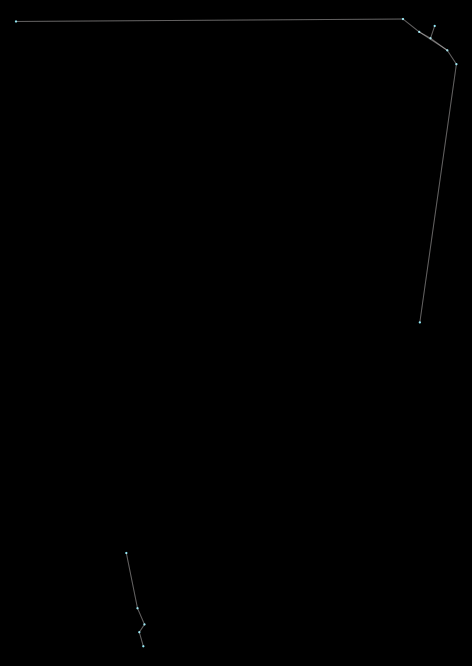

In [161]:
fig, ax = pt.generate_plot(G)
default_size = fig.get_size_inches()

fig.set_size_inches(default_size[0]*1, default_size[1]*1)


In [162]:
routes_area

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
37,205,ARST SPA,Linea 205,SANLURI - GUSPINI - ARBUS - FLUMINIMAGGIORE,NaN,3,http://www.arstspa.info/205.pdf,0000FF,ffffff
152,804,ARST SPA,Linea 804,BUGGERRU - IGLESIAS,NaN,3,http://www.arstspa.info/804.pdf,0000FF,ffffff
156,808,ARST SPA,Linea 808,MASUA - IGLESIAS - DOMUSNOVAS,NaN,3,http://www.arstspa.info/808.pdf,0000FF,ffffff
187,840,ARST SPA,Linea 840,MASUA - DOMUSNOVAS,NaN,3,http://www.arstspa.info/840.pdf,0000FF,ffffff
204,857,ARST SPA,Linea 857,PORTIXEDDU - FLUMINIMAGGIORE,NaN,3,http://www.arstspa.info/857.pdf,0000FF,ffffff


In [163]:
stops_area.to_file('stops_area.geojson',driver='GeoJSON')